In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap
from sklearn.utils.class_weight import compute_class_weight

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-18 05:37:58.811842: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 05:37:58.875576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 05:38:01.914941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0818_variable.csv')
test = pd.read_csv('./data/test_0818_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'dist_head_stage1', 'dist_head_stage2',
       'dist_head_stage3', 'RESIN Adjusted_Predicted_Volume Stage1 Dam',
       'RESIN Adjusted_Predicted_Volume Stage2 Dam',
       'RESIN Adjusted_Predicted_Volume Stage3 Dam',
       'RESIN Adjusted_Predicted_Volume Stage1 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage2 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage3 Fill1', 'time_per_pressure_1st',
       'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage1',
       'circle_stage2', 'circle_stage3', 'line_stage1', 'line_stage2',
       'line_stage3', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
       'select_workorder', 'CURE SPEED Collect Result_Dam',
       'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
       'Production Qty Collect Result_Dam',
       'Chamber Temp. Collect Result_AutoClave',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 

In [6]:
# 학습시 inconsistant 전부 빼고 적용
train_sel = train[train['inconsistant'] == 0]

In [7]:
# 각 영역별 
stage1 = [
    'target', 'dist_head_stage1',
    'RESIN Adjusted_Predicted_Volume Stage1 Dam',
    'RESIN Adjusted_Predicted_Volume Stage1 Fill1', 'time_per_pressure_1st',
    'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage1',
    'line_stage1', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
    'CURE SPEED Collect Result_Dam',
    'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
    'Chamber Temp. Collect Result_AutoClave', 
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    '1st Pressure Collect Result_AutoClave',
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    '3rd Pressure Unit Time_AutoClave'
]

stage2 = [
    'target', 'dist_head_stage2',
    'RESIN Adjusted_Predicted_Volume Stage2 Dam',
    'RESIN Adjusted_Predicted_Volume Stage2 Fill1',
    'time_per_pressure_1st',
    'time_per_pressure_2nd', 'time_per_pressure_3rd',
    'circle_stage2', 'line_stage2', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
    'CURE SPEED Collect Result_Dam',
    'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
    'Chamber Temp. Collect Result_AutoClave',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    '1st Pressure Collect Result_AutoClave',
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    '3rd Pressure Unit Time_AutoClave'
]

stage3 = [
    'target', 'dist_head_stage3', 
    'RESIN Adjusted_Predicted_Volume Stage3 Dam',
    'RESIN Adjusted_Predicted_Volume Stage3 Fill1', 'time_per_pressure_1st',
    'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage3',
    'line_stage3', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
    'CURE SPEED Collect Result_Dam',
    'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
    'Chamber Temp. Collect Result_AutoClave',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    '1st Pressure Collect Result_AutoClave',
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    '3rd Pressure Unit Time_AutoClave'
]

df_stage1 = train_sel[stage1]
df_stage2 = train_sel[stage2]
df_stage3 = train_sel[stage3]

# Stage1

In [8]:
X_stage1 = df_stage1.drop(columns=['target'])
y_stage1 = df_stage1['target']

cat_features_indices_stage1 = []

X_train, X_valid, y_train, y_valid = train_test_split(X_stage1, y_stage1, test_size=0.2, random_state=42, stratify = y_stage1)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage1)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage1)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
# Sampler 생성 시 random seed 설정
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 05:38:08,777] A new study created in memory with name: no-name-93ca85f5-6b69-468d-b129-0f7e56fae1b0
[I 2024-08-18 05:38:10,814] Trial 0 finished with value: 0.5076518593564507 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5076518593564507.
[I 2024-08-18 05:38:14,580] Trial 1 finished with value: 0.4901274784212227 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5076518593564507.
[I 2024-08-18 05:38:37,755] Trial 2 finished with value: 0.5076

[I 2024-08-18 05:39:13,509] Trial 20 finished with value: 0.5076518593564507 and parameters: {'iterations': 760, 'depth': 6, 'learning_rate': 0.019067594876368447, 'l2_leaf_reg': 9.914636380800225, 'border_count': 184, 'random_strength': 8.932881140715871, 'bagging_temperature': 0.9069186216472911, 'od_type': 'IncToDec', 'od_wait': 19, 'boosting_type': 'Plain'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:39:15,482] Trial 21 finished with value: 0.5119397058437197 and parameters: {'iterations': 298, 'depth': 6, 'learning_rate': 0.24723923343212692, 'l2_leaf_reg': 6.126005651777306, 'border_count': 227, 'random_strength': 3.7077038425717257, 'bagging_temperature': 0.25077858873660175, 'od_type': 'Iter', 'od_wait': 31, 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:39:17,263] Trial 22 finished with value: 0.5160938738689484 and parameters: {'iterations': 290, 'depth': 5, 'learning_rate': 0.5225910001917167, 'l2_leaf_reg'

[I 2024-08-18 05:40:20,427] Trial 40 finished with value: 0.48565065224307985 and parameters: {'iterations': 237, 'depth': 8, 'learning_rate': 0.0015585373391649527, 'l2_leaf_reg': 6.972824932022456, 'border_count': 75, 'random_strength': 4.553745279356912, 'bagging_temperature': 0.6456120000997929, 'od_type': 'Iter', 'od_wait': 30, 'boosting_type': 'Plain'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:40:24,269] Trial 41 finished with value: 0.5160938738689484 and parameters: {'iterations': 401, 'depth': 6, 'learning_rate': 0.15316187834102132, 'l2_leaf_reg': 6.313866434881503, 'border_count': 232, 'random_strength': 4.833830831882971, 'bagging_temperature': 0.0896953606999295, 'od_type': 'Iter', 'od_wait': 36, 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:40:25,391] Trial 42 finished with value: 0.5054189879703123 and parameters: {'iterations': 349, 'depth': 6, 'learning_rate': 0.7345422991108257, 'l2_leaf_reg': 4.4

Best trial:
  Value: 0.5181004602905481
  Params: 
    iterations: 592
    depth: 5
    learning_rate: 0.8105016126411579
    l2_leaf_reg: 7.7535769053775345
    border_count: 242
    random_strength: 8.94827350438166
    bagging_temperature: 0.5978999788110851
    od_type: IncToDec
    od_wait: 18
    boosting_type: Plain


In [9]:
study.best_trial.params

{'iterations': 592,
 'depth': 5,
 'learning_rate': 0.8105016126411579,
 'l2_leaf_reg': 7.7535769053775345,
 'border_count': 242,
 'random_strength': 8.94827350438166,
 'bagging_temperature': 0.5978999788110851,
 'od_type': 'IncToDec',
 'od_wait': 18,
 'boosting_type': 'Plain'}

In [10]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = study.best_trial.params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage1)

0:	learn: 0.2230752	total: 3.81ms	remaining: 2.25s
1:	learn: 0.2123394	total: 7.55ms	remaining: 2.23s
2:	learn: 0.2091889	total: 11.5ms	remaining: 2.26s
3:	learn: 0.2090023	total: 14.6ms	remaining: 2.14s
4:	learn: 0.2084485	total: 18.4ms	remaining: 2.16s
5:	learn: 0.2081482	total: 22ms	remaining: 2.15s
6:	learn: 0.2078955	total: 25.4ms	remaining: 2.12s
7:	learn: 0.2076097	total: 29.5ms	remaining: 2.15s
8:	learn: 0.2070663	total: 33.5ms	remaining: 2.17s
9:	learn: 0.2068370	total: 36.8ms	remaining: 2.14s
10:	learn: 0.2064310	total: 40.5ms	remaining: 2.14s
11:	learn: 0.2056498	total: 44.6ms	remaining: 2.16s
12:	learn: 0.2053755	total: 48.5ms	remaining: 2.16s
13:	learn: 0.2050219	total: 52.5ms	remaining: 2.17s
14:	learn: 0.2042747	total: 55.8ms	remaining: 2.15s
15:	learn: 0.2039030	total: 59.6ms	remaining: 2.15s
16:	learn: 0.2034571	total: 63.5ms	remaining: 2.15s
17:	learn: 0.2027436	total: 67.2ms	remaining: 2.14s
18:	learn: 0.2020300	total: 70.7ms	remaining: 2.13s
19:	learn: 0.2017517	tot

201:	learn: 0.1483575	total: 774ms	remaining: 1.49s
202:	learn: 0.1481475	total: 778ms	remaining: 1.49s
203:	learn: 0.1478392	total: 783ms	remaining: 1.49s
204:	learn: 0.1476216	total: 787ms	remaining: 1.49s
205:	learn: 0.1474744	total: 791ms	remaining: 1.48s
206:	learn: 0.1473850	total: 795ms	remaining: 1.48s
207:	learn: 0.1471922	total: 799ms	remaining: 1.47s
208:	learn: 0.1471844	total: 803ms	remaining: 1.47s
209:	learn: 0.1470783	total: 807ms	remaining: 1.47s
210:	learn: 0.1469456	total: 811ms	remaining: 1.46s
211:	learn: 0.1468360	total: 815ms	remaining: 1.46s
212:	learn: 0.1465224	total: 819ms	remaining: 1.46s
213:	learn: 0.1463936	total: 822ms	remaining: 1.45s
214:	learn: 0.1461602	total: 826ms	remaining: 1.45s
215:	learn: 0.1461500	total: 829ms	remaining: 1.44s
216:	learn: 0.1461489	total: 833ms	remaining: 1.44s
217:	learn: 0.1461215	total: 837ms	remaining: 1.44s
218:	learn: 0.1459712	total: 840ms	remaining: 1.43s
219:	learn: 0.1459428	total: 844ms	remaining: 1.43s
220:	learn: 

364:	learn: 0.1218672	total: 1.4s	remaining: 872ms
365:	learn: 0.1218133	total: 1.41s	remaining: 869ms
366:	learn: 0.1216535	total: 1.41s	remaining: 865ms
367:	learn: 0.1215147	total: 1.41s	remaining: 861ms
368:	learn: 0.1213651	total: 1.42s	remaining: 857ms
369:	learn: 0.1213293	total: 1.42s	remaining: 854ms
370:	learn: 0.1212178	total: 1.43s	remaining: 850ms
371:	learn: 0.1211692	total: 1.43s	remaining: 846ms
372:	learn: 0.1210716	total: 1.43s	remaining: 842ms
373:	learn: 0.1209785	total: 1.44s	remaining: 838ms
374:	learn: 0.1208084	total: 1.44s	remaining: 834ms
375:	learn: 0.1206628	total: 1.45s	remaining: 831ms
376:	learn: 0.1205362	total: 1.45s	remaining: 827ms
377:	learn: 0.1203779	total: 1.45s	remaining: 823ms
378:	learn: 0.1201605	total: 1.46s	remaining: 819ms
379:	learn: 0.1199718	total: 1.46s	remaining: 815ms
380:	learn: 0.1197756	total: 1.47s	remaining: 812ms
381:	learn: 0.1195820	total: 1.47s	remaining: 808ms
382:	learn: 0.1194040	total: 1.47s	remaining: 804ms
383:	learn: 0

563:	learn: 0.0966633	total: 2.18s	remaining: 108ms
564:	learn: 0.0965750	total: 2.19s	remaining: 104ms
565:	learn: 0.0964683	total: 2.19s	remaining: 101ms
566:	learn: 0.0963250	total: 2.19s	remaining: 96.7ms
567:	learn: 0.0963009	total: 2.2s	remaining: 92.9ms
568:	learn: 0.0961983	total: 2.2s	remaining: 89ms
569:	learn: 0.0960544	total: 2.21s	remaining: 85.2ms
570:	learn: 0.0958718	total: 2.21s	remaining: 81.3ms
571:	learn: 0.0956849	total: 2.21s	remaining: 77.5ms
572:	learn: 0.0955658	total: 2.22s	remaining: 73.6ms
573:	learn: 0.0954611	total: 2.22s	remaining: 69.8ms
574:	learn: 0.0953998	total: 2.23s	remaining: 65.9ms
575:	learn: 0.0952255	total: 2.23s	remaining: 62ms
576:	learn: 0.0951023	total: 2.23s	remaining: 58.1ms
577:	learn: 0.0949721	total: 2.24s	remaining: 54.3ms
578:	learn: 0.0947788	total: 2.24s	remaining: 50.4ms
579:	learn: 0.0946888	total: 2.25s	remaining: 46.5ms
580:	learn: 0.0945148	total: 2.25s	remaining: 42.6ms
581:	learn: 0.0944382	total: 2.25s	remaining: 38.8ms
58

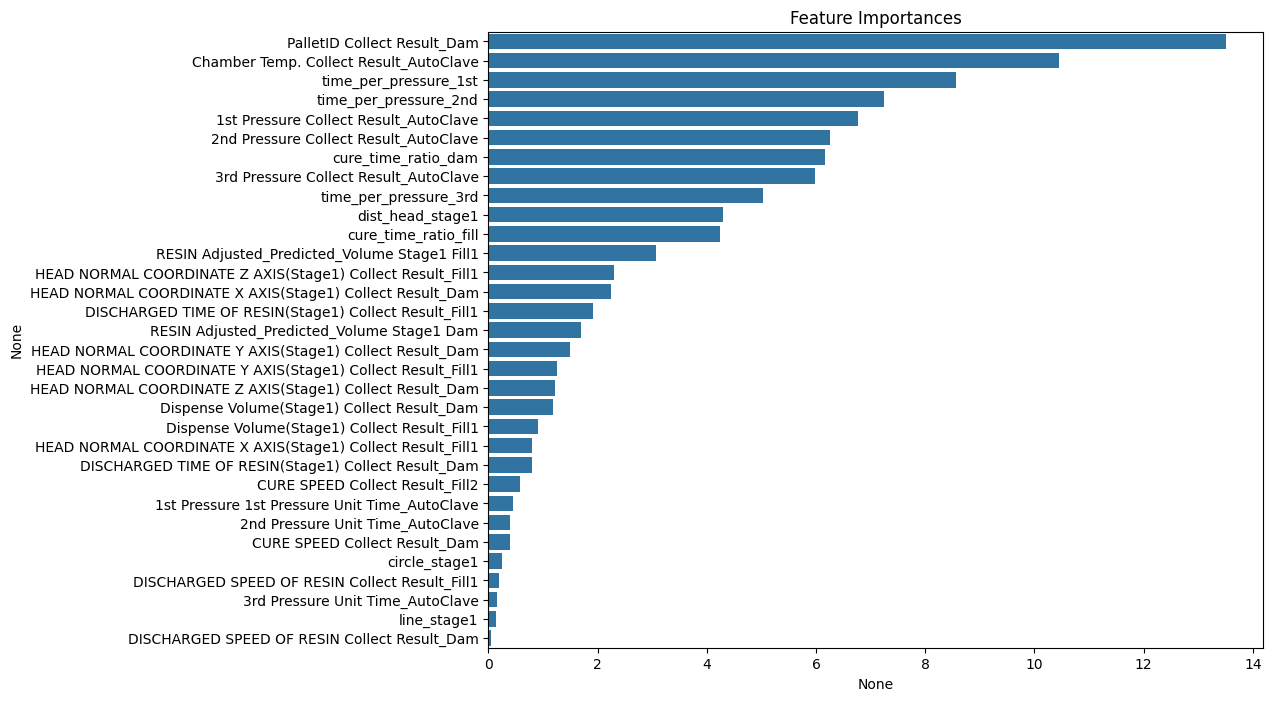

In [11]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [12]:
pred = stage1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  34  417]
 [  88 7544]]

정확도: 0.9375
정밀도: 0.2787
재현율: 0.0754
F1: 0.1187


In [13]:
# Precision - Recall
y_pred_proba = stage1_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds_stage1 = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage1[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  81  370]
 [ 499 7133]]

정확도: 0.8925
정밀도: 0.1397
재현율: 0.1796
F1: 0.1571


In [14]:
cat_best_threshold

0.1640362634701001

# Stage2

In [15]:
X_stage2 = df_stage2.drop(columns=['target'])
y_stage2 = df_stage2['target']

cat_features_indices_stage2 = []

X_train, X_valid, y_train, y_valid = train_test_split(X_stage2, y_stage2, test_size=0.2, random_state=42, stratify = y_stage2)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage2)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage2)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 05:40:42,213] A new study created in memory with name: no-name-a2640171-2aee-4457-8938-bb6742804522
[I 2024-08-18 05:40:44,521] Trial 0 finished with value: 0.5139769879735077 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5139769879735077.
[I 2024-08-18 05:40:47,929] Trial 1 finished with value: 0.4901274784212227 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5139769879735077.
[I 2024-08-18 05:41:12,593] Trial 2 finished with value: 0.5076

[I 2024-08-18 05:42:13,462] Trial 20 finished with value: 0.5117627601282844 and parameters: {'iterations': 411, 'depth': 8, 'learning_rate': 0.06677432459925477, 'l2_leaf_reg': 0.141396983707466, 'border_count': 159, 'random_strength': 2.0289171530474173, 'bagging_temperature': 0.9608771169328997, 'od_type': 'Iter', 'od_wait': 31, 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:42:36,772] Trial 21 finished with value: 0.5076518593564507 and parameters: {'iterations': 841, 'depth': 7, 'learning_rate': 0.012278620999022547, 'l2_leaf_reg': 8.51162203821907, 'border_count': 251, 'random_strength': 3.5833210913410207, 'bagging_temperature': 0.8442303531004518, 'od_type': 'Iter', 'od_wait': 26, 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:42:56,521] Trial 22 finished with value: 0.5118511149469208 and parameters: {'iterations': 712, 'depth': 7, 'learning_rate': 0.020865116845656093, 'l2_leaf_reg':

[I 2024-08-18 05:44:09,935] Trial 40 finished with value: 0.5138842568546513 and parameters: {'iterations': 274, 'depth': 4, 'learning_rate': 0.12723050944129938, 'l2_leaf_reg': 4.570450600464255, 'border_count': 75, 'random_strength': 0.28560431647307283, 'bagging_temperature': 0.12261099484257403, 'od_type': 'IncToDec', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:44:12,329] Trial 41 finished with value: 0.5097161965309348 and parameters: {'iterations': 360, 'depth': 6, 'learning_rate': 0.1560786149625403, 'l2_leaf_reg': 2.983630413130551, 'border_count': 242, 'random_strength': 2.5518308976684634, 'bagging_temperature': 0.16805332144074275, 'od_type': 'IncToDec', 'od_wait': 24, 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.5181004602905481.
[I 2024-08-18 05:44:17,403] Trial 42 finished with value: 0.4901274784212227 and parameters: {'iterations': 179, 'depth': 7, 'learning_rate': 0.013099834278157575, 'l2_lea

Best trial:
  Value: 0.5181004602905481
  Params: 
    iterations: 592
    depth: 5
    learning_rate: 0.8105016126411579
    l2_leaf_reg: 7.7535769053775345
    border_count: 242
    random_strength: 8.94827350438166
    bagging_temperature: 0.5978999788110851
    od_type: IncToDec
    od_wait: 18
    boosting_type: Plain


In [16]:
study.best_trial.params

{'iterations': 592,
 'depth': 5,
 'learning_rate': 0.8105016126411579,
 'l2_leaf_reg': 7.7535769053775345,
 'border_count': 242,
 'random_strength': 8.94827350438166,
 'bagging_temperature': 0.5978999788110851,
 'od_type': 'IncToDec',
 'od_wait': 18,
 'boosting_type': 'Plain'}

In [17]:
# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = study.best_trial.params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage2)

0:	learn: 0.2228970	total: 3.93ms	remaining: 2.33s
1:	learn: 0.2123597	total: 7.96ms	remaining: 2.35s
2:	learn: 0.2090218	total: 12ms	remaining: 2.37s
3:	learn: 0.2088252	total: 15.2ms	remaining: 2.23s
4:	learn: 0.2082752	total: 19ms	remaining: 2.23s
5:	learn: 0.2077332	total: 22.9ms	remaining: 2.23s
6:	learn: 0.2074607	total: 26.3ms	remaining: 2.2s
7:	learn: 0.2062370	total: 30.5ms	remaining: 2.23s
8:	learn: 0.2058712	total: 34.5ms	remaining: 2.23s
9:	learn: 0.2056242	total: 38.1ms	remaining: 2.22s
10:	learn: 0.2054849	total: 41.6ms	remaining: 2.2s
11:	learn: 0.2048260	total: 45.7ms	remaining: 2.21s
12:	learn: 0.2047077	total: 49.3ms	remaining: 2.19s
13:	learn: 0.2041065	total: 52.9ms	remaining: 2.18s
14:	learn: 0.2037036	total: 56.3ms	remaining: 2.16s
15:	learn: 0.2031788	total: 60.7ms	remaining: 2.18s
16:	learn: 0.2024642	total: 64.4ms	remaining: 2.18s
17:	learn: 0.2017372	total: 68.3ms	remaining: 2.18s
18:	learn: 0.2016613	total: 71.8ms	remaining: 2.17s
19:	learn: 0.2012549	total: 

200:	learn: 0.1475641	total: 772ms	remaining: 1.5s
201:	learn: 0.1474732	total: 776ms	remaining: 1.5s
202:	learn: 0.1473469	total: 780ms	remaining: 1.49s
203:	learn: 0.1472157	total: 783ms	remaining: 1.49s
204:	learn: 0.1468783	total: 787ms	remaining: 1.49s
205:	learn: 0.1467589	total: 791ms	remaining: 1.48s
206:	learn: 0.1465221	total: 795ms	remaining: 1.48s
207:	learn: 0.1464442	total: 799ms	remaining: 1.47s
208:	learn: 0.1461481	total: 803ms	remaining: 1.47s
209:	learn: 0.1461204	total: 806ms	remaining: 1.47s
210:	learn: 0.1459752	total: 810ms	remaining: 1.46s
211:	learn: 0.1457081	total: 814ms	remaining: 1.46s
212:	learn: 0.1454301	total: 818ms	remaining: 1.46s
213:	learn: 0.1452873	total: 822ms	remaining: 1.45s
214:	learn: 0.1451734	total: 825ms	remaining: 1.45s
215:	learn: 0.1450660	total: 829ms	remaining: 1.44s
216:	learn: 0.1450054	total: 833ms	remaining: 1.44s
217:	learn: 0.1447641	total: 836ms	remaining: 1.44s
218:	learn: 0.1446113	total: 840ms	remaining: 1.43s
219:	learn: 0.

364:	learn: 0.1226420	total: 1.41s	remaining: 877ms
365:	learn: 0.1226304	total: 1.41s	remaining: 873ms
366:	learn: 0.1223912	total: 1.42s	remaining: 870ms
367:	learn: 0.1221562	total: 1.42s	remaining: 866ms
368:	learn: 0.1219835	total: 1.43s	remaining: 862ms
369:	learn: 0.1218241	total: 1.43s	remaining: 858ms
370:	learn: 0.1217553	total: 1.43s	remaining: 854ms
371:	learn: 0.1214924	total: 1.44s	remaining: 850ms
372:	learn: 0.1213712	total: 1.44s	remaining: 846ms
373:	learn: 0.1210978	total: 1.45s	remaining: 843ms
374:	learn: 0.1208437	total: 1.45s	remaining: 839ms
375:	learn: 0.1207116	total: 1.45s	remaining: 835ms
376:	learn: 0.1205975	total: 1.46s	remaining: 831ms
377:	learn: 0.1204874	total: 1.46s	remaining: 827ms
378:	learn: 0.1204052	total: 1.46s	remaining: 823ms
379:	learn: 0.1201901	total: 1.47s	remaining: 819ms
380:	learn: 0.1199168	total: 1.47s	remaining: 815ms
381:	learn: 0.1198760	total: 1.48s	remaining: 811ms
382:	learn: 0.1196599	total: 1.48s	remaining: 807ms
383:	learn: 

562:	learn: 0.0979467	total: 2.18s	remaining: 112ms
563:	learn: 0.0979042	total: 2.19s	remaining: 109ms
564:	learn: 0.0977458	total: 2.19s	remaining: 105ms
565:	learn: 0.0976653	total: 2.19s	remaining: 101ms
566:	learn: 0.0974507	total: 2.2s	remaining: 96.9ms
567:	learn: 0.0973515	total: 2.2s	remaining: 93.1ms
568:	learn: 0.0972006	total: 2.21s	remaining: 89.2ms
569:	learn: 0.0970399	total: 2.21s	remaining: 85.3ms
570:	learn: 0.0969749	total: 2.21s	remaining: 81.5ms
571:	learn: 0.0969295	total: 2.22s	remaining: 77.6ms
572:	learn: 0.0966914	total: 2.22s	remaining: 73.7ms
573:	learn: 0.0965827	total: 2.23s	remaining: 69.8ms
574:	learn: 0.0964982	total: 2.23s	remaining: 66ms
575:	learn: 0.0964105	total: 2.23s	remaining: 62.1ms
576:	learn: 0.0962645	total: 2.24s	remaining: 58.2ms
577:	learn: 0.0962031	total: 2.24s	remaining: 54.3ms
578:	learn: 0.0961442	total: 2.25s	remaining: 50.5ms
579:	learn: 0.0961213	total: 2.25s	remaining: 46.6ms
580:	learn: 0.0960320	total: 2.25s	remaining: 42.7ms
5

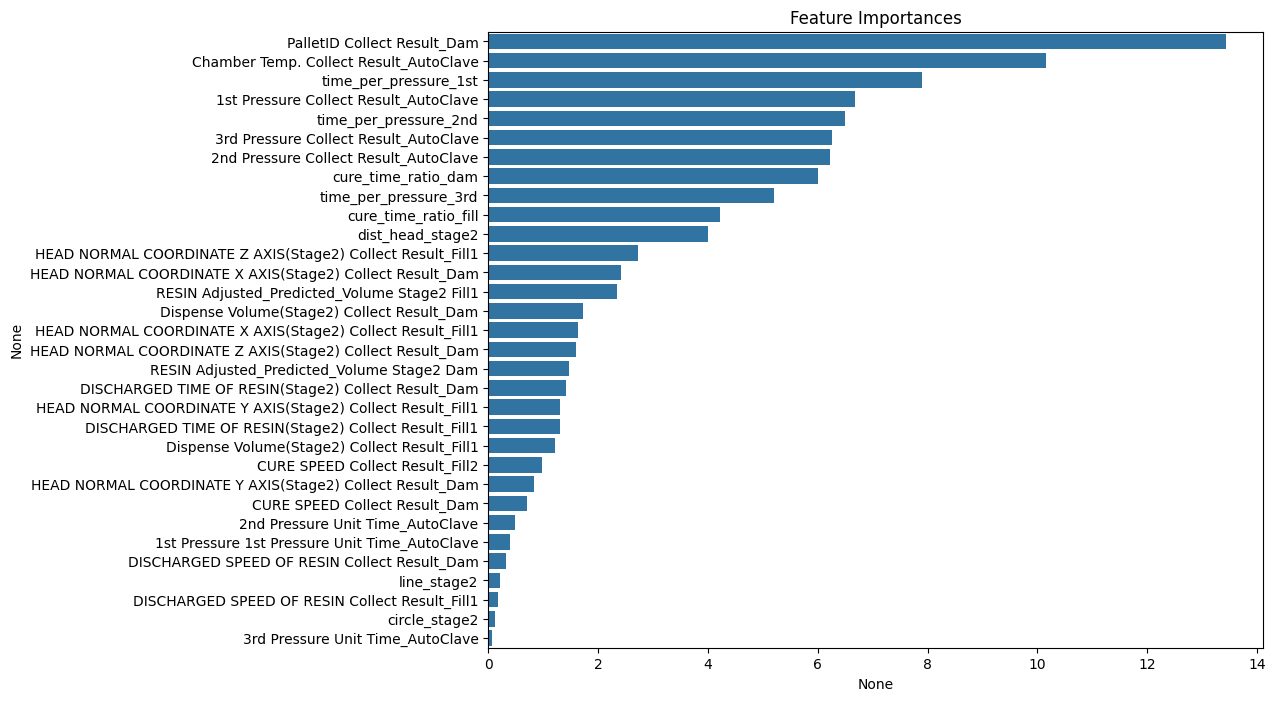

In [18]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [19]:
pred = stage2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  26  425]
 [  82 7550]]

정확도: 0.9373
정밀도: 0.2407
재현율: 0.0576
F1: 0.0930


In [20]:
# Precision - Recall
y_pred_proba = stage2_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds_stage2 = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage2[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[ 139  312]
 [1318 6314]]

정확도: 0.7983
정밀도: 0.0954
재현율: 0.3082
F1: 0.1457


In [21]:
cat_best_threshold

0.07126683190789926

# Stage3

In [22]:
X_stage3 = df_stage3.drop(columns=['target'])
y_stage3 = df_stage3['target']

cat_features_indices_stage3 = []

X_train, X_valid, y_train, y_valid = train_test_split(X_stage3, y_stage3, test_size=0.2, random_state=42, stratify = y_stage3)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage3)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage3)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 05:44:50,746] A new study created in memory with name: no-name-e9b7ac3f-ab22-415c-a2d5-24b8914f9ea1
[I 2024-08-18 05:44:52,501] Trial 0 finished with value: 0.5119397058437197 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5119397058437197.
[I 2024-08-18 05:44:55,903] Trial 1 finished with value: 0.4901274784212227 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5119397058437197.
[I 2024-08-18 05:45:19,579] Trial 2 finished with value: 0.5076

[I 2024-08-18 05:48:01,103] Trial 20 finished with value: 0.5119397058437197 and parameters: {'iterations': 853, 'depth': 7, 'learning_rate': 0.05070682930000401, 'l2_leaf_reg': 4.5802814649603985, 'border_count': 192, 'random_strength': 0.08532664651580024, 'bagging_temperature': 0.7186461403566584, 'od_type': 'Iter', 'od_wait': 12, 'boosting_type': 'Ordered'}. Best is trial 12 with value: 0.5161912158187308.
[I 2024-08-18 05:48:06,289] Trial 21 finished with value: 0.5160938738689484 and parameters: {'iterations': 297, 'depth': 6, 'learning_rate': 0.0801495399578019, 'l2_leaf_reg': 6.042261049638915, 'border_count': 222, 'random_strength': 4.274802977648166, 'bagging_temperature': 0.530067201729179, 'od_type': 'Iter', 'od_wait': 30, 'boosting_type': 'Ordered'}. Best is trial 12 with value: 0.5161912158187308.
[I 2024-08-18 05:48:08,861] Trial 22 finished with value: 0.5161912158187308 and parameters: {'iterations': 688, 'depth': 5, 'learning_rate': 0.21866555585219163, 'l2_leaf_reg':

[I 2024-08-18 05:49:05,965] Trial 40 finished with value: 0.5119397058437197 and parameters: {'iterations': 805, 'depth': 5, 'learning_rate': 0.2556792494969801, 'l2_leaf_reg': 7.003115023103525, 'border_count': 238, 'random_strength': 2.870240139043834, 'bagging_temperature': 0.09842425239638106, 'od_type': 'IncToDec', 'od_wait': 38, 'boosting_type': 'Ordered'}. Best is trial 12 with value: 0.5161912158187308.
[I 2024-08-18 05:49:09,807] Trial 41 finished with value: 0.5161912158187308 and parameters: {'iterations': 387, 'depth': 6, 'learning_rate': 0.12022339500645152, 'l2_leaf_reg': 5.928041029446197, 'border_count': 225, 'random_strength': 4.462123841680757, 'bagging_temperature': 0.12220672383841615, 'od_type': 'Iter', 'od_wait': 33, 'boosting_type': 'Ordered'}. Best is trial 12 with value: 0.5161912158187308.
[I 2024-08-18 05:49:14,111] Trial 42 finished with value: 0.5159968044446427 and parameters: {'iterations': 345, 'depth': 6, 'learning_rate': 0.1560769801571914, 'l2_leaf_re

Best trial:
  Value: 0.5161912158187308
  Params: 
    iterations: 732
    depth: 7
    learning_rate: 0.03414254748487734
    l2_leaf_reg: 9.416179460932371
    border_count: 205
    random_strength: 2.8962008578506273
    bagging_temperature: 0.9130313467526872
    od_type: Iter
    od_wait: 28
    boosting_type: Ordered


In [23]:
study.best_trial.params

{'iterations': 732,
 'depth': 7,
 'learning_rate': 0.03414254748487734,
 'l2_leaf_reg': 9.416179460932371,
 'border_count': 205,
 'random_strength': 2.8962008578506273,
 'bagging_temperature': 0.9130313467526872,
 'od_type': 'Iter',
 'od_wait': 28,
 'boosting_type': 'Ordered'}

In [24]:
# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = study.best_trial.params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage3)

0:	learn: 0.6505131	total: 28.7ms	remaining: 21s
1:	learn: 0.6117885	total: 57.3ms	remaining: 20.9s
2:	learn: 0.5764358	total: 84.7ms	remaining: 20.6s
3:	learn: 0.5443815	total: 113ms	remaining: 20.5s
4:	learn: 0.5153164	total: 141ms	remaining: 20.4s
5:	learn: 0.4885956	total: 169ms	remaining: 20.4s
6:	learn: 0.4641658	total: 197ms	remaining: 20.4s
7:	learn: 0.4424021	total: 224ms	remaining: 20.3s
8:	learn: 0.4222401	total: 252ms	remaining: 20.2s
9:	learn: 0.4040565	total: 280ms	remaining: 20.2s
10:	learn: 0.3875456	total: 307ms	remaining: 20.2s
11:	learn: 0.3724522	total: 329ms	remaining: 19.8s
12:	learn: 0.3588823	total: 357ms	remaining: 19.8s
13:	learn: 0.3459937	total: 385ms	remaining: 19.7s
14:	learn: 0.3345775	total: 412ms	remaining: 19.7s
15:	learn: 0.3242820	total: 439ms	remaining: 19.7s
16:	learn: 0.3146934	total: 467ms	remaining: 19.7s
17:	learn: 0.3059113	total: 496ms	remaining: 19.7s
18:	learn: 0.2981482	total: 522ms	remaining: 19.6s
19:	learn: 0.2908843	total: 550ms	remain

165:	learn: 0.2040574	total: 4.56s	remaining: 15.5s
166:	learn: 0.2040127	total: 4.58s	remaining: 15.5s
167:	learn: 0.2040010	total: 4.61s	remaining: 15.5s
168:	learn: 0.2039810	total: 4.64s	remaining: 15.5s
169:	learn: 0.2039614	total: 4.67s	remaining: 15.4s
170:	learn: 0.2039100	total: 4.7s	remaining: 15.4s
171:	learn: 0.2038700	total: 4.72s	remaining: 15.4s
172:	learn: 0.2038344	total: 4.75s	remaining: 15.4s
173:	learn: 0.2038218	total: 4.77s	remaining: 15.3s
174:	learn: 0.2037841	total: 4.8s	remaining: 15.3s
175:	learn: 0.2037681	total: 4.83s	remaining: 15.2s
176:	learn: 0.2037472	total: 4.86s	remaining: 15.2s
177:	learn: 0.2037464	total: 4.87s	remaining: 15.2s
178:	learn: 0.2037189	total: 4.9s	remaining: 15.1s
179:	learn: 0.2037034	total: 4.93s	remaining: 15.1s
180:	learn: 0.2036903	total: 4.96s	remaining: 15.1s
181:	learn: 0.2036575	total: 4.98s	remaining: 15.1s
182:	learn: 0.2036202	total: 5.01s	remaining: 15s
183:	learn: 0.2036022	total: 5.04s	remaining: 15s
184:	learn: 0.20356

326:	learn: 0.2009434	total: 8.94s	remaining: 11.1s
327:	learn: 0.2009324	total: 8.96s	remaining: 11s
328:	learn: 0.2008944	total: 8.99s	remaining: 11s
329:	learn: 0.2008539	total: 9.02s	remaining: 11s
330:	learn: 0.2008282	total: 9.05s	remaining: 11s
331:	learn: 0.2008063	total: 9.07s	remaining: 10.9s
332:	learn: 0.2007699	total: 9.1s	remaining: 10.9s
333:	learn: 0.2007599	total: 9.13s	remaining: 10.9s
334:	learn: 0.2007036	total: 9.16s	remaining: 10.9s
335:	learn: 0.2006954	total: 9.18s	remaining: 10.8s
336:	learn: 0.2006848	total: 9.21s	remaining: 10.8s
337:	learn: 0.2006675	total: 9.24s	remaining: 10.8s
338:	learn: 0.2006444	total: 9.27s	remaining: 10.7s
339:	learn: 0.2006408	total: 9.29s	remaining: 10.7s
340:	learn: 0.2006078	total: 9.31s	remaining: 10.7s
341:	learn: 0.2006012	total: 9.34s	remaining: 10.7s
342:	learn: 0.2005880	total: 9.37s	remaining: 10.6s
343:	learn: 0.2005622	total: 9.4s	remaining: 10.6s
344:	learn: 0.2005309	total: 9.43s	remaining: 10.6s
345:	learn: 0.2004971	

486:	learn: 0.1964848	total: 13.4s	remaining: 6.72s
487:	learn: 0.1964709	total: 13.4s	remaining: 6.7s
488:	learn: 0.1964475	total: 13.4s	remaining: 6.67s
489:	learn: 0.1964374	total: 13.5s	remaining: 6.64s
490:	learn: 0.1964267	total: 13.5s	remaining: 6.62s
491:	learn: 0.1964039	total: 13.5s	remaining: 6.59s
492:	learn: 0.1963791	total: 13.5s	remaining: 6.56s
493:	learn: 0.1963609	total: 13.6s	remaining: 6.53s
494:	learn: 0.1962915	total: 13.6s	remaining: 6.51s
495:	learn: 0.1962718	total: 13.6s	remaining: 6.48s
496:	learn: 0.1962405	total: 13.7s	remaining: 6.46s
497:	learn: 0.1962333	total: 13.7s	remaining: 6.43s
498:	learn: 0.1961936	total: 13.7s	remaining: 6.4s
499:	learn: 0.1961819	total: 13.7s	remaining: 6.37s
500:	learn: 0.1961642	total: 13.8s	remaining: 6.34s
501:	learn: 0.1961417	total: 13.8s	remaining: 6.32s
502:	learn: 0.1961321	total: 13.8s	remaining: 6.29s
503:	learn: 0.1961126	total: 13.8s	remaining: 6.26s
504:	learn: 0.1960983	total: 13.9s	remaining: 6.24s
505:	learn: 0.

646:	learn: 0.1939242	total: 17.8s	remaining: 2.34s
647:	learn: 0.1938599	total: 17.8s	remaining: 2.31s
648:	learn: 0.1938534	total: 17.9s	remaining: 2.29s
649:	learn: 0.1938432	total: 17.9s	remaining: 2.26s
650:	learn: 0.1938232	total: 17.9s	remaining: 2.23s
651:	learn: 0.1938147	total: 18s	remaining: 2.2s
652:	learn: 0.1937488	total: 18s	remaining: 2.18s
653:	learn: 0.1937362	total: 18s	remaining: 2.15s
654:	learn: 0.1937192	total: 18s	remaining: 2.12s
655:	learn: 0.1936979	total: 18.1s	remaining: 2.09s
656:	learn: 0.1936711	total: 18.1s	remaining: 2.07s
657:	learn: 0.1936688	total: 18.1s	remaining: 2.04s
658:	learn: 0.1936463	total: 18.2s	remaining: 2.01s
659:	learn: 0.1936433	total: 18.2s	remaining: 1.98s
660:	learn: 0.1936208	total: 18.2s	remaining: 1.96s
661:	learn: 0.1936104	total: 18.2s	remaining: 1.93s
662:	learn: 0.1936008	total: 18.3s	remaining: 1.9s
663:	learn: 0.1935750	total: 18.3s	remaining: 1.87s
664:	learn: 0.1935637	total: 18.3s	remaining: 1.85s
665:	learn: 0.1935273	

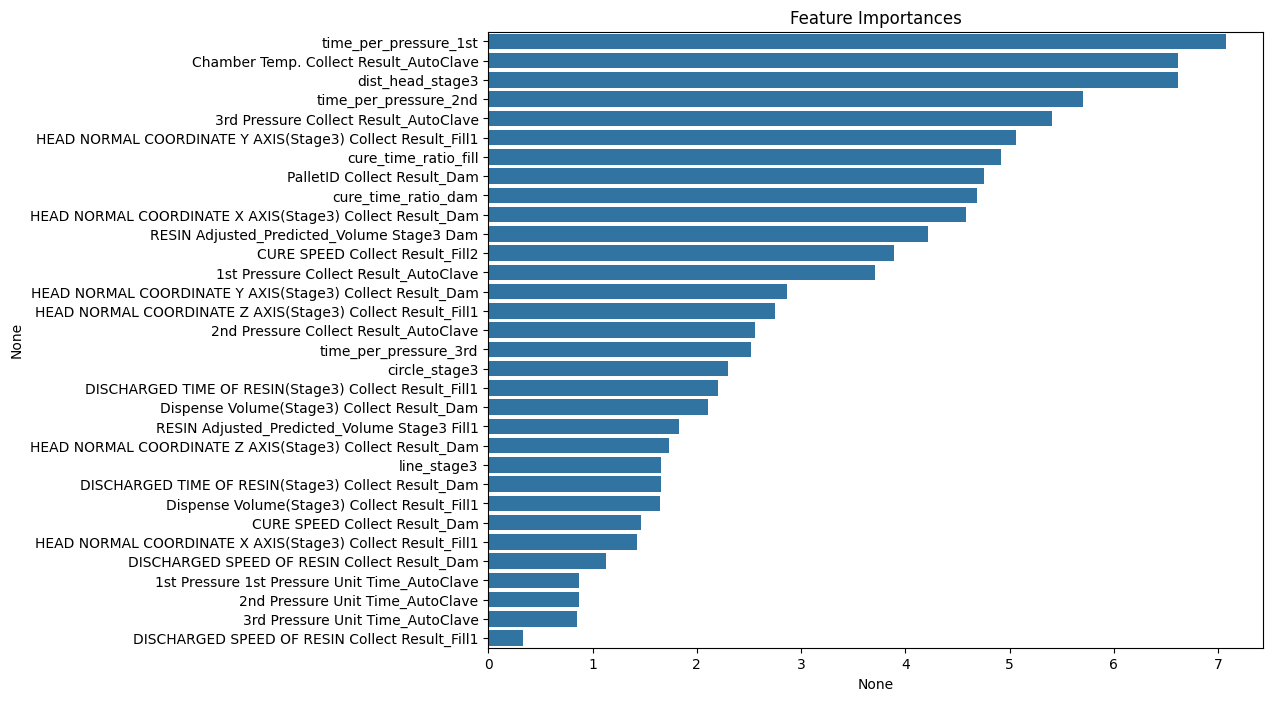

In [25]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage3_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [26]:
pred = stage3_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  14  437]
 [   0 7632]]

정확도: 0.9459
정밀도: 1.0000
재현율: 0.0310
F1: 0.0602


In [27]:
# Precision - Recall
y_pred_proba = stage3_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds_stage3 = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage3[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[ 193  258]
 [1546 6086]]

정확도: 0.7768
정밀도: 0.1110
재현율: 0.4279
F1: 0.1763


In [28]:
cat_best_threshold

0.07088232989289812

# 민감성

In [29]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = stage1_best_params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_stage1, y_stage1, cat_features=cat_features_indices_stage1)

# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = stage2_best_params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_stage2, y_stage2, cat_features=cat_features_indices_stage2)

# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = stage3_best_params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_stage3, y_stage3, cat_features=cat_features_indices_stage3)

0:	learn: 0.2229663	total: 4.74ms	remaining: 2.8s
1:	learn: 0.2123227	total: 9.61ms	remaining: 2.83s
2:	learn: 0.2091803	total: 14.7ms	remaining: 2.89s
3:	learn: 0.2086814	total: 18.7ms	remaining: 2.74s
4:	learn: 0.2081961	total: 23.1ms	remaining: 2.72s
5:	learn: 0.2073819	total: 28.2ms	remaining: 2.76s
6:	learn: 0.2067493	total: 33ms	remaining: 2.76s
7:	learn: 0.2066236	total: 37.4ms	remaining: 2.73s
8:	learn: 0.2062946	total: 42ms	remaining: 2.72s
9:	learn: 0.2061229	total: 46.8ms	remaining: 2.72s
10:	learn: 0.2060512	total: 51ms	remaining: 2.69s
11:	learn: 0.2058454	total: 56ms	remaining: 2.71s
12:	learn: 0.2057652	total: 60.5ms	remaining: 2.69s
13:	learn: 0.2055671	total: 64.9ms	remaining: 2.68s
14:	learn: 0.2053192	total: 69.2ms	remaining: 2.66s
15:	learn: 0.2042307	total: 73.5ms	remaining: 2.65s
16:	learn: 0.2032697	total: 78.3ms	remaining: 2.65s
17:	learn: 0.2030756	total: 82.5ms	remaining: 2.63s
18:	learn: 0.2029592	total: 86.9ms	remaining: 2.62s
19:	learn: 0.2024947	total: 91.

167:	learn: 0.1615347	total: 765ms	remaining: 1.93s
168:	learn: 0.1614881	total: 770ms	remaining: 1.93s
169:	learn: 0.1612812	total: 774ms	remaining: 1.92s
170:	learn: 0.1612271	total: 778ms	remaining: 1.92s
171:	learn: 0.1610594	total: 783ms	remaining: 1.91s
172:	learn: 0.1607766	total: 788ms	remaining: 1.91s
173:	learn: 0.1606707	total: 792ms	remaining: 1.9s
174:	learn: 0.1604667	total: 797ms	remaining: 1.9s
175:	learn: 0.1604667	total: 800ms	remaining: 1.89s
176:	learn: 0.1602238	total: 804ms	remaining: 1.89s
177:	learn: 0.1600574	total: 809ms	remaining: 1.88s
178:	learn: 0.1597977	total: 814ms	remaining: 1.88s
179:	learn: 0.1595947	total: 819ms	remaining: 1.87s
180:	learn: 0.1593694	total: 823ms	remaining: 1.87s
181:	learn: 0.1590678	total: 828ms	remaining: 1.86s
182:	learn: 0.1588152	total: 833ms	remaining: 1.86s
183:	learn: 0.1586350	total: 838ms	remaining: 1.86s
184:	learn: 0.1584720	total: 843ms	remaining: 1.85s
185:	learn: 0.1580479	total: 848ms	remaining: 1.85s
186:	learn: 0.

332:	learn: 0.1370044	total: 1.53s	remaining: 1.19s
333:	learn: 0.1368374	total: 1.54s	remaining: 1.19s
334:	learn: 0.1367205	total: 1.54s	remaining: 1.18s
335:	learn: 0.1366752	total: 1.55s	remaining: 1.18s
336:	learn: 0.1364126	total: 1.55s	remaining: 1.17s
337:	learn: 0.1361744	total: 1.55s	remaining: 1.17s
338:	learn: 0.1361051	total: 1.56s	remaining: 1.16s
339:	learn: 0.1358423	total: 1.56s	remaining: 1.16s
340:	learn: 0.1357950	total: 1.57s	remaining: 1.16s
341:	learn: 0.1356346	total: 1.57s	remaining: 1.15s
342:	learn: 0.1355849	total: 1.58s	remaining: 1.15s
343:	learn: 0.1354793	total: 1.58s	remaining: 1.14s
344:	learn: 0.1354483	total: 1.59s	remaining: 1.14s
345:	learn: 0.1353490	total: 1.59s	remaining: 1.13s
346:	learn: 0.1351567	total: 1.6s	remaining: 1.13s
347:	learn: 0.1350488	total: 1.6s	remaining: 1.12s
348:	learn: 0.1349149	total: 1.61s	remaining: 1.12s
349:	learn: 0.1348128	total: 1.61s	remaining: 1.11s
350:	learn: 0.1346950	total: 1.61s	remaining: 1.11s
351:	learn: 0.

506:	learn: 0.1171845	total: 2.34s	remaining: 392ms
507:	learn: 0.1171570	total: 2.34s	remaining: 387ms
508:	learn: 0.1170719	total: 2.35s	remaining: 383ms
509:	learn: 0.1169007	total: 2.35s	remaining: 378ms
510:	learn: 0.1167536	total: 2.36s	remaining: 374ms
511:	learn: 0.1165832	total: 2.36s	remaining: 369ms
512:	learn: 0.1164946	total: 2.37s	remaining: 364ms
513:	learn: 0.1164865	total: 2.37s	remaining: 360ms
514:	learn: 0.1164576	total: 2.38s	remaining: 355ms
515:	learn: 0.1163654	total: 2.38s	remaining: 351ms
516:	learn: 0.1163440	total: 2.38s	remaining: 346ms
517:	learn: 0.1162781	total: 2.39s	remaining: 341ms
518:	learn: 0.1161069	total: 2.39s	remaining: 337ms
519:	learn: 0.1160118	total: 2.4s	remaining: 332ms
520:	learn: 0.1158965	total: 2.4s	remaining: 328ms
521:	learn: 0.1158316	total: 2.41s	remaining: 323ms
522:	learn: 0.1157262	total: 2.41s	remaining: 318ms
523:	learn: 0.1155288	total: 2.42s	remaining: 314ms
524:	learn: 0.1154469	total: 2.42s	remaining: 309ms
525:	learn: 0.

87:	learn: 0.1809043	total: 405ms	remaining: 2.32s
88:	learn: 0.1807115	total: 410ms	remaining: 2.31s
89:	learn: 0.1803942	total: 414ms	remaining: 2.31s
90:	learn: 0.1799929	total: 419ms	remaining: 2.3s
91:	learn: 0.1796420	total: 423ms	remaining: 2.3s
92:	learn: 0.1792756	total: 427ms	remaining: 2.29s
93:	learn: 0.1788716	total: 432ms	remaining: 2.29s
94:	learn: 0.1786516	total: 437ms	remaining: 2.28s
95:	learn: 0.1784817	total: 441ms	remaining: 2.28s
96:	learn: 0.1783869	total: 446ms	remaining: 2.27s
97:	learn: 0.1778893	total: 451ms	remaining: 2.27s
98:	learn: 0.1775856	total: 456ms	remaining: 2.27s
99:	learn: 0.1773755	total: 461ms	remaining: 2.27s
100:	learn: 0.1772809	total: 466ms	remaining: 2.26s
101:	learn: 0.1771312	total: 470ms	remaining: 2.26s
102:	learn: 0.1770449	total: 475ms	remaining: 2.25s
103:	learn: 0.1767614	total: 480ms	remaining: 2.25s
104:	learn: 0.1766922	total: 484ms	remaining: 2.25s
105:	learn: 0.1765524	total: 489ms	remaining: 2.24s
106:	learn: 0.1761970	total

261:	learn: 0.1468048	total: 1.21s	remaining: 1.52s
262:	learn: 0.1465411	total: 1.22s	remaining: 1.52s
263:	learn: 0.1463465	total: 1.22s	remaining: 1.52s
264:	learn: 0.1462127	total: 1.23s	remaining: 1.51s
265:	learn: 0.1461108	total: 1.23s	remaining: 1.51s
266:	learn: 0.1459848	total: 1.23s	remaining: 1.5s
267:	learn: 0.1458507	total: 1.24s	remaining: 1.5s
268:	learn: 0.1456879	total: 1.24s	remaining: 1.49s
269:	learn: 0.1456443	total: 1.25s	remaining: 1.49s
270:	learn: 0.1455753	total: 1.25s	remaining: 1.48s
271:	learn: 0.1453729	total: 1.26s	remaining: 1.48s
272:	learn: 0.1453670	total: 1.26s	remaining: 1.47s
273:	learn: 0.1452310	total: 1.27s	remaining: 1.47s
274:	learn: 0.1448943	total: 1.27s	remaining: 1.47s
275:	learn: 0.1446973	total: 1.28s	remaining: 1.46s
276:	learn: 0.1446518	total: 1.28s	remaining: 1.46s
277:	learn: 0.1445954	total: 1.28s	remaining: 1.45s
278:	learn: 0.1443369	total: 1.29s	remaining: 1.45s
279:	learn: 0.1441628	total: 1.29s	remaining: 1.44s
280:	learn: 0.

435:	learn: 0.1237711	total: 2.02s	remaining: 722ms
436:	learn: 0.1236482	total: 2.02s	remaining: 717ms
437:	learn: 0.1236127	total: 2.03s	remaining: 713ms
438:	learn: 0.1234654	total: 2.03s	remaining: 708ms
439:	learn: 0.1232921	total: 2.04s	remaining: 703ms
440:	learn: 0.1231692	total: 2.04s	remaining: 699ms
441:	learn: 0.1229475	total: 2.04s	remaining: 694ms
442:	learn: 0.1228659	total: 2.05s	remaining: 689ms
443:	learn: 0.1228383	total: 2.05s	remaining: 685ms
444:	learn: 0.1227401	total: 2.06s	remaining: 680ms
445:	learn: 0.1225943	total: 2.06s	remaining: 676ms
446:	learn: 0.1225852	total: 2.07s	remaining: 671ms
447:	learn: 0.1224374	total: 2.07s	remaining: 667ms
448:	learn: 0.1222954	total: 2.08s	remaining: 662ms
449:	learn: 0.1222319	total: 2.08s	remaining: 657ms
450:	learn: 0.1221442	total: 2.09s	remaining: 653ms
451:	learn: 0.1221039	total: 2.09s	remaining: 648ms
452:	learn: 0.1219346	total: 2.1s	remaining: 643ms
453:	learn: 0.1218717	total: 2.1s	remaining: 639ms
454:	learn: 0.

1:	learn: 0.6118443	total: 61.8ms	remaining: 22.6s
2:	learn: 0.5768271	total: 85.9ms	remaining: 20.9s
3:	learn: 0.5449881	total: 116ms	remaining: 21s
4:	learn: 0.5158098	total: 145ms	remaining: 21s
5:	learn: 0.4895098	total: 173ms	remaining: 21s
6:	learn: 0.4656061	total: 203ms	remaining: 21s
7:	learn: 0.4436281	total: 232ms	remaining: 21s
8:	learn: 0.4237550	total: 264ms	remaining: 21.2s
9:	learn: 0.4054126	total: 294ms	remaining: 21.3s
10:	learn: 0.3889216	total: 325ms	remaining: 21.3s
11:	learn: 0.3736702	total: 354ms	remaining: 21.3s
12:	learn: 0.3598013	total: 384ms	remaining: 21.2s
13:	learn: 0.3473522	total: 412ms	remaining: 21.1s
14:	learn: 0.3360227	total: 443ms	remaining: 21.2s
15:	learn: 0.3256872	total: 473ms	remaining: 21.2s
16:	learn: 0.3164003	total: 490ms	remaining: 20.6s
17:	learn: 0.3076032	total: 519ms	remaining: 20.6s
18:	learn: 0.2995040	total: 548ms	remaining: 20.6s
19:	learn: 0.2923351	total: 578ms	remaining: 20.6s
20:	learn: 0.2857917	total: 607ms	remaining: 20.

162:	learn: 0.2042893	total: 4.73s	remaining: 16.5s
163:	learn: 0.2042564	total: 4.76s	remaining: 16.5s
164:	learn: 0.2042192	total: 4.79s	remaining: 16.5s
165:	learn: 0.2042045	total: 4.81s	remaining: 16.4s
166:	learn: 0.2041491	total: 4.84s	remaining: 16.4s
167:	learn: 0.2041234	total: 4.86s	remaining: 16.3s
168:	learn: 0.2040906	total: 4.89s	remaining: 16.3s
169:	learn: 0.2040905	total: 4.9s	remaining: 16.2s
170:	learn: 0.2040715	total: 4.93s	remaining: 16.2s
171:	learn: 0.2040443	total: 4.96s	remaining: 16.2s
172:	learn: 0.2040260	total: 4.99s	remaining: 16.1s
173:	learn: 0.2040180	total: 5.02s	remaining: 16.1s
174:	learn: 0.2040040	total: 5.05s	remaining: 16.1s
175:	learn: 0.2039795	total: 5.08s	remaining: 16.1s
176:	learn: 0.2039553	total: 5.11s	remaining: 16s
177:	learn: 0.2039411	total: 5.14s	remaining: 16s
178:	learn: 0.2039128	total: 5.17s	remaining: 16s
179:	learn: 0.2038904	total: 5.2s	remaining: 16s
180:	learn: 0.2038640	total: 5.23s	remaining: 15.9s
181:	learn: 0.2038505	

322:	learn: 0.2015178	total: 9.31s	remaining: 11.8s
323:	learn: 0.2015028	total: 9.34s	remaining: 11.8s
324:	learn: 0.2014849	total: 9.37s	remaining: 11.7s
325:	learn: 0.2014792	total: 9.4s	remaining: 11.7s
326:	learn: 0.2014627	total: 9.43s	remaining: 11.7s
327:	learn: 0.2014553	total: 9.46s	remaining: 11.7s
328:	learn: 0.2014489	total: 9.49s	remaining: 11.6s
329:	learn: 0.2014459	total: 9.52s	remaining: 11.6s
330:	learn: 0.2014292	total: 9.55s	remaining: 11.6s
331:	learn: 0.2014246	total: 9.58s	remaining: 11.5s
332:	learn: 0.2014185	total: 9.61s	remaining: 11.5s
333:	learn: 0.2013916	total: 9.64s	remaining: 11.5s
334:	learn: 0.2013678	total: 9.67s	remaining: 11.5s
335:	learn: 0.2013352	total: 9.7s	remaining: 11.4s
336:	learn: 0.2013079	total: 9.73s	remaining: 11.4s
337:	learn: 0.2012783	total: 9.76s	remaining: 11.4s
338:	learn: 0.2012611	total: 9.79s	remaining: 11.3s
339:	learn: 0.2012431	total: 9.82s	remaining: 11.3s
340:	learn: 0.2012163	total: 9.85s	remaining: 11.3s
341:	learn: 0.

483:	learn: 0.1968227	total: 14.1s	remaining: 7.22s
484:	learn: 0.1967874	total: 14.1s	remaining: 7.19s
485:	learn: 0.1967499	total: 14.2s	remaining: 7.16s
486:	learn: 0.1967309	total: 14.2s	remaining: 7.13s
487:	learn: 0.1966937	total: 14.2s	remaining: 7.11s
488:	learn: 0.1966511	total: 14.2s	remaining: 7.08s
489:	learn: 0.1966318	total: 14.3s	remaining: 7.05s
490:	learn: 0.1966053	total: 14.3s	remaining: 7.02s
491:	learn: 0.1965589	total: 14.3s	remaining: 6.99s
492:	learn: 0.1965281	total: 14.4s	remaining: 6.96s
493:	learn: 0.1965130	total: 14.4s	remaining: 6.93s
494:	learn: 0.1964939	total: 14.4s	remaining: 6.9s
495:	learn: 0.1964623	total: 14.4s	remaining: 6.88s
496:	learn: 0.1963907	total: 14.5s	remaining: 6.85s
497:	learn: 0.1963634	total: 14.5s	remaining: 6.82s
498:	learn: 0.1963509	total: 14.5s	remaining: 6.79s
499:	learn: 0.1963375	total: 14.6s	remaining: 6.76s
500:	learn: 0.1962935	total: 14.6s	remaining: 6.73s
501:	learn: 0.1962614	total: 14.6s	remaining: 6.7s
502:	learn: 0.

644:	learn: 0.1934043	total: 18.9s	remaining: 2.55s
645:	learn: 0.1933844	total: 19s	remaining: 2.52s
646:	learn: 0.1933542	total: 19s	remaining: 2.5s
647:	learn: 0.1933242	total: 19s	remaining: 2.47s
648:	learn: 0.1933139	total: 19.1s	remaining: 2.44s
649:	learn: 0.1932972	total: 19.1s	remaining: 2.41s
650:	learn: 0.1932813	total: 19.1s	remaining: 2.38s
651:	learn: 0.1932772	total: 19.1s	remaining: 2.35s
652:	learn: 0.1932647	total: 19.2s	remaining: 2.32s
653:	learn: 0.1932490	total: 19.2s	remaining: 2.29s
654:	learn: 0.1932208	total: 19.2s	remaining: 2.26s
655:	learn: 0.1932055	total: 19.3s	remaining: 2.23s
656:	learn: 0.1931874	total: 19.3s	remaining: 2.2s
657:	learn: 0.1931583	total: 19.3s	remaining: 2.17s
658:	learn: 0.1931290	total: 19.4s	remaining: 2.14s
659:	learn: 0.1931089	total: 19.4s	remaining: 2.12s
660:	learn: 0.1931009	total: 19.4s	remaining: 2.09s
661:	learn: 0.1930936	total: 19.5s	remaining: 2.06s
662:	learn: 0.1930860	total: 19.5s	remaining: 2.03s
663:	learn: 0.193078

In [30]:
test_stage1_x = test[X_stage1.columns]
test_stage2_x = test[X_stage2.columns]
test_stage3_x = test[X_stage3.columns]

In [31]:
# Precision - Recall
y_pred_proba = stage1_best_model.predict_proba(test_stage1_x)[:, 1]

# precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage1[np.argmax(f1_scores)]
y_pred_custom_threshold_stage1 = (y_pred_proba >= cat_best_threshold).astype(int)

In [32]:
# Precision - Recall
y_pred_proba = stage2_best_model.predict_proba(test_stage2_x)[:, 1]

f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage2[np.argmax(f1_scores)]
y_pred_custom_threshold_stage2 = (y_pred_proba >= cat_best_threshold).astype(int)

In [33]:
# Precision - Recall
y_pred_proba = stage3_best_model.predict_proba(test_stage3_x)[:, 1]

f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage3[np.argmax(f1_scores)]
y_pred_custom_threshold_stage3 = (y_pred_proba >= cat_best_threshold).astype(int)

In [34]:
result = np.logical_or(y_pred_custom_threshold_stage1, y_pred_custom_threshold_stage2)
result = np.logical_or(result, y_pred_custom_threshold_stage3)

In [35]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [36]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 7119, 10242]))

In [37]:
test['target'] = y_pred

In [38]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,7100,10233
1,19,9


In [39]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [40]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,7100,10233
1,28,0


In [41]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

### Explain

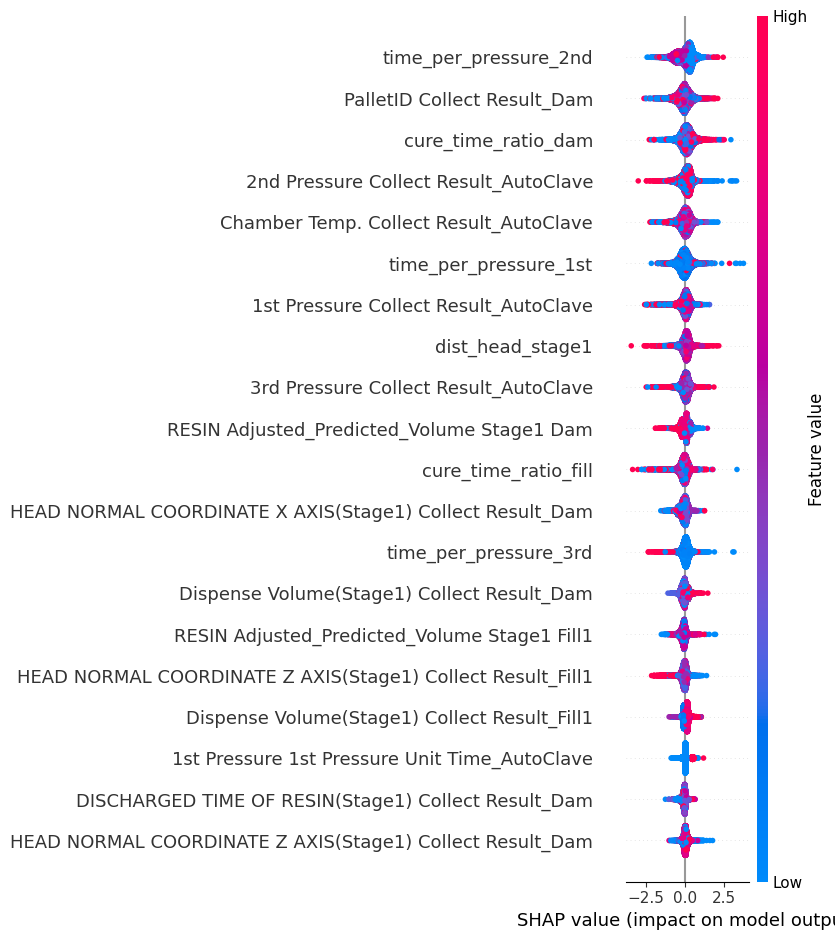

In [42]:
explainer = shap.Explainer(stage1_best_model)
shap_values = explainer(test_stage1_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage1_x)

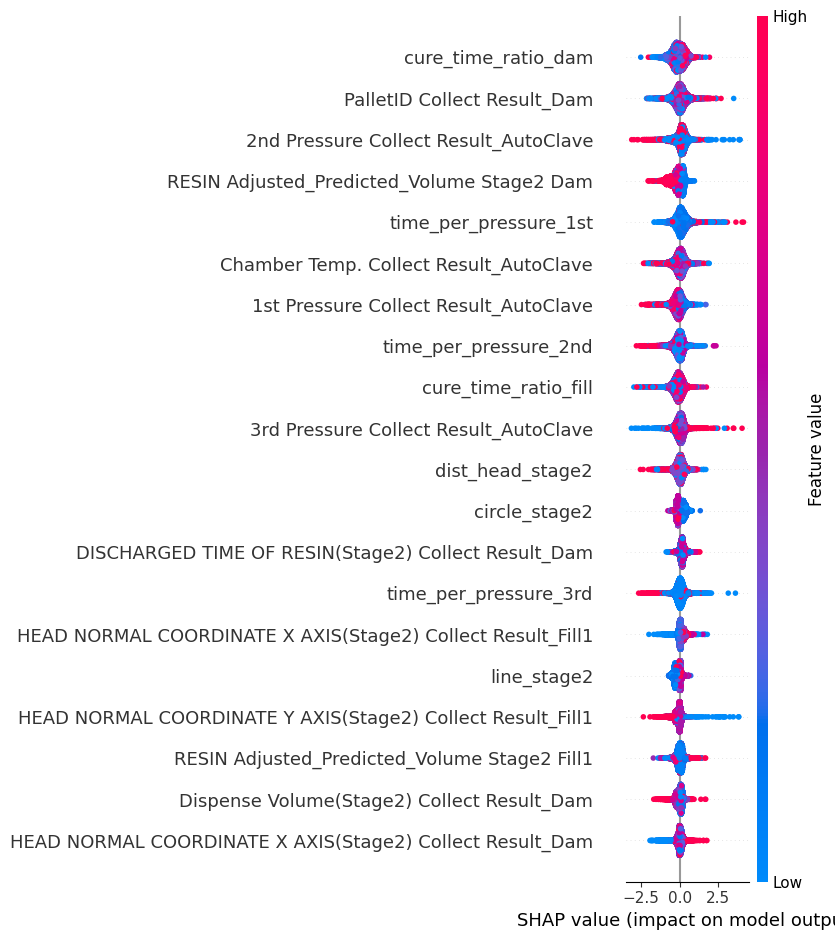

In [43]:
explainer = shap.Explainer(stage2_best_model)
shap_values = explainer(test_stage2_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage2_x)

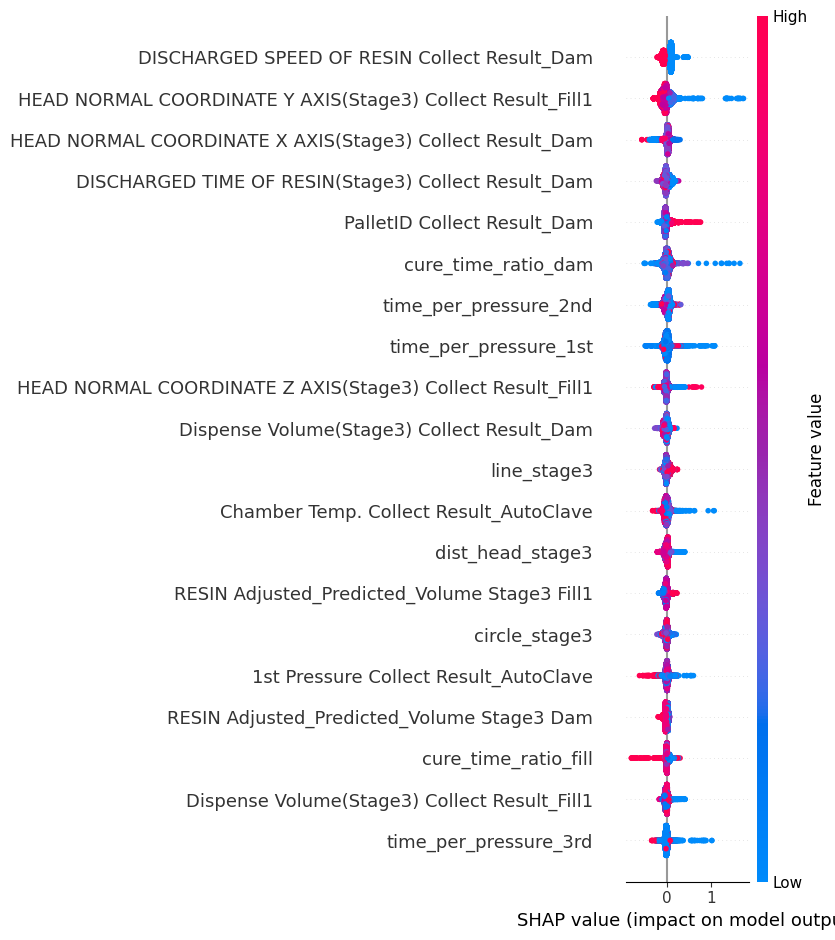

In [44]:
explainer = shap.Explainer(stage3_best_model)
shap_values = explainer(test_stage3_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage3_x)

In [45]:
stage1_test_pred = stage1_best_model.predict(test_stage1_x)
stage1_test_pred

array([0, 0, 0, ..., 0, 1, 0])

In [46]:
stage2_test_pred = stage2_best_model.predict(test_stage2_x)
stage2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
stage3_test_pred = stage3_best_model.predict(test_stage3_x)
stage3_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
result = np.logical_or(stage1_test_pred, stage2_test_pred)
result = np.logical_or(result, stage3_test_pred)

In [49]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [50]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  443, 16918]))

In [51]:
test['target'] = y_pred

In [52]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,440,16893
1,3,25


In [53]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [54]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,440,16893
1,28,0


In [55]:
test.columns

Index(['Set ID', 'inconsistant', 'dist_head_stage1', 'dist_head_stage2',
       'dist_head_stage3', 'RESIN Adjusted_Predicted_Volume Stage1 Dam',
       'RESIN Adjusted_Predicted_Volume Stage2 Dam',
       'RESIN Adjusted_Predicted_Volume Stage3 Dam',
       'RESIN Adjusted_Predicted_Volume Stage1 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage2 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage3 Fill1', 'time_per_pressure_1st',
       'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage1',
       'circle_stage2', 'circle_stage3', 'line_stage1', 'line_stage2',
       'line_stage3', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
       'select_workorder', 'CURE SPEED Collect Result_Dam',
       'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
       'Production Qty Collect Result_Dam',
       'Chamber Temp. Collect Result_AutoClave',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 

<Axes: >

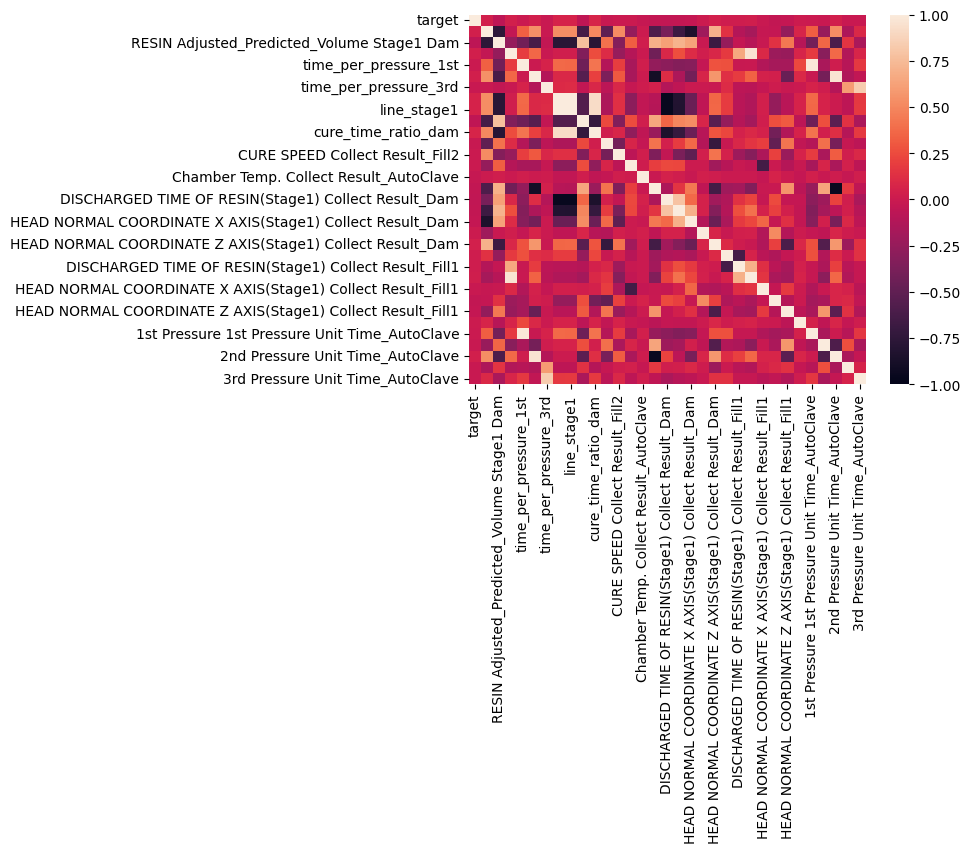

In [56]:
sns.heatmap(df_stage1.corr(), vmin=-1, vmax=1)

<Axes: >

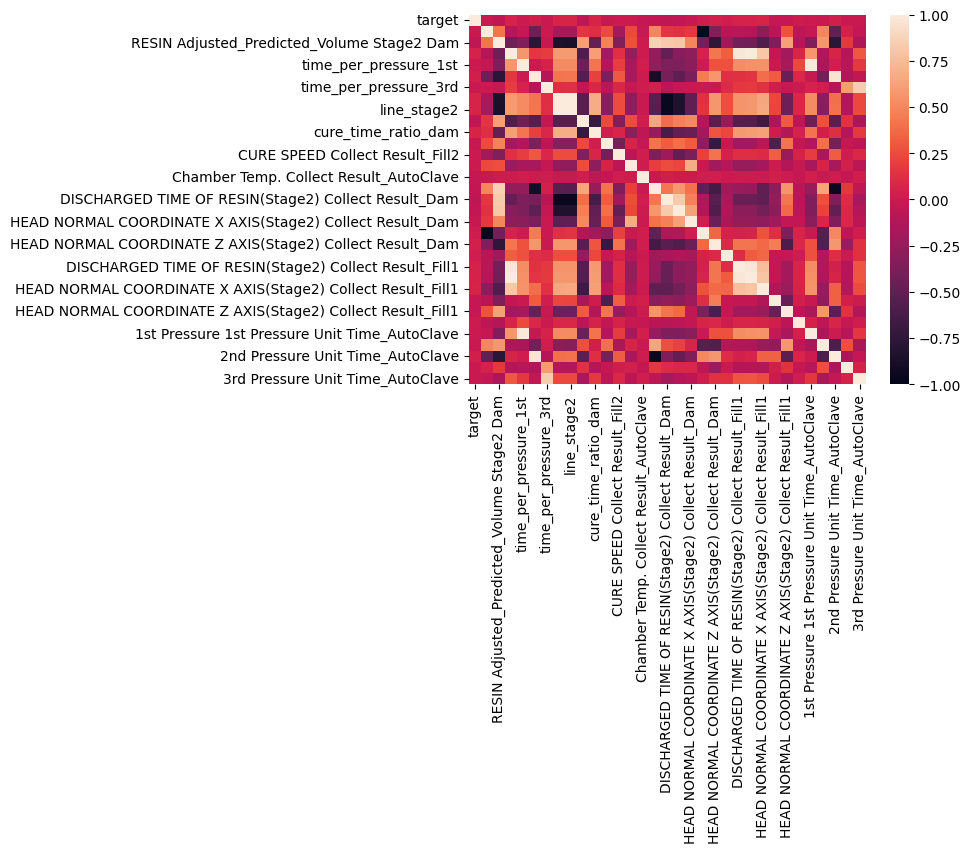

In [57]:
sns.heatmap(df_stage2.corr(), vmin=-1, vmax=1)

<Axes: >

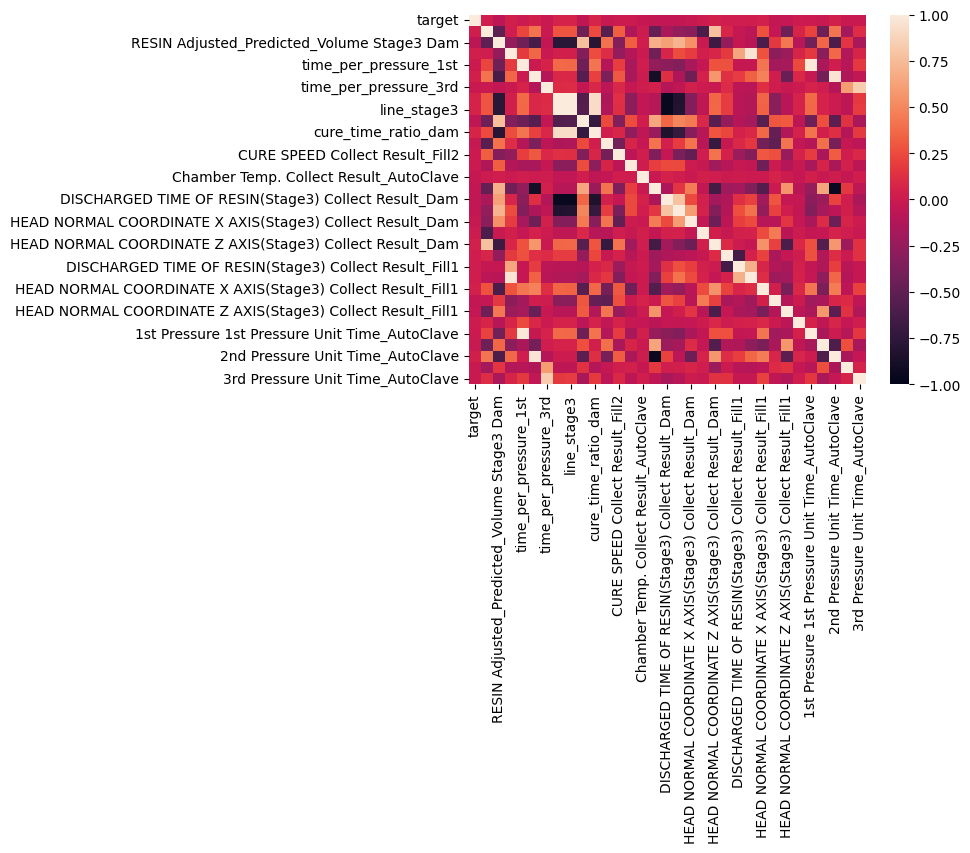

In [58]:
sns.heatmap(df_stage3.corr(), vmin=-1, vmax=1)

<Axes: >

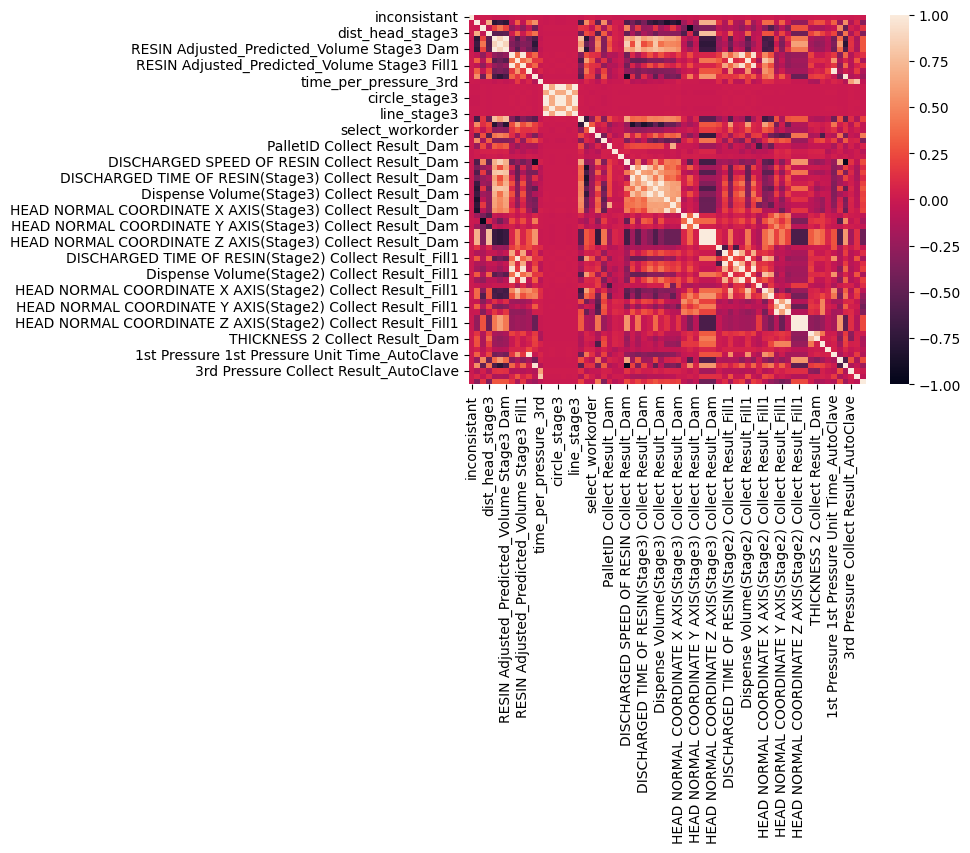

In [59]:
sns.heatmap(test.iloc[:, 1:-1].corr(), vmin=-1, vmax=1)

In [60]:
# # 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
# df_sub = pd.read_csv("submission.csv")
# df_sub["target"] = y_pred

# # 제출 파일 저장
# df_sub.to_csv("submission.csv", index=False)